<a href="https://colab.research.google.com/github/mamuyy/Aplikasi-analisis-saham/blob/main/pds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



<ipython-input-24-0c07b41a4991>:53: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data.drop(columns=['BB_Std'], inplace=True)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.1820 - val_loss: 0.0206
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0195 - val_loss: 0.0150
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0143 - val_loss: 0.0134
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0133 - val_loss: 0.0147
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0147 - val_loss: 0.0128
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0129 - val_loss: 0.0180
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0149 - val_l

,Model,MAE,RMSE
0,LSTM,0.069399,0.087503
1,XGBoost,0.015944,0.022164


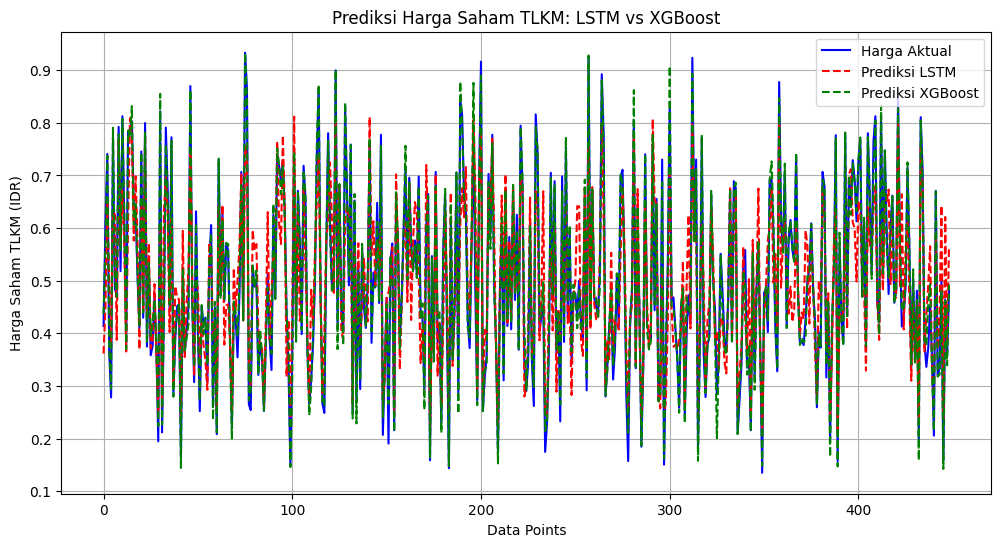

In [24]:
# 📌 Install library yang diperlukan
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow xgboost

# 📌 Import pustaka yang dibutuhkan
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 📌 Ambil data saham TLKM dari Yahoo Finance (2015-2025)
ticker = "TLKM.JK"
data = yf.download(ticker, start="2015-01-01", end="2025-01-01")
data.reset_index(inplace=True)
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# 📌 Hitung indikator teknikal (Ichimoku, RSI, MACD, Bollinger Bands, VWAP, Fibonacci)
data['Tenkan_sen'] = (data['High'].rolling(9).max() + data['Low'].rolling(9).min()) / 2
data['Kijun_sen'] = (data['High'].rolling(26).max() + data['Low'].rolling(26).min()) / 2
data['Senkou_Span_A'] = ((data['Tenkan_sen'] + data['Kijun_sen']) / 2).shift(26)
data['Senkou_Span_B'] = ((data['High'].rolling(52).max() + data['Low'].rolling(52).min()) / 2).shift(26)

# 📌 RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

# 📌 MACD
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# 📌 Bollinger Bands
data['BB_Middle'] = data['Close'].rolling(window=20).mean()
data['BB_Std'] = data['Close'].rolling(window=20).std()
data['BB_Upper'] = data['BB_Middle'] + 2 * data['BB_Std']
data['BB_Lower'] = data['BB_Middle'] - 2 * data['BB_Std']
data.drop(columns=['BB_Std'], inplace=True)

# 📌 VWAP
data['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

# 📌 Fibonacci Retracement
def compute_fibonacci_levels(data):
    high_price = data['High'].rolling(50).max()
    low_price = data['Low'].rolling(50).min()
    diff = high_price - low_price
    data['Fib_236'] = high_price - (diff * 0.236)
    data['Fib_382'] = high_price - (diff * 0.382)
    data['Fib_500'] = high_price - (diff * 0.500)
    data['Fib_618'] = high_price - (diff * 0.618)
    data['Fib_786'] = high_price - (diff * 0.786)

compute_fibonacci_levels(data)

# 📌 Hapus NaN dengan interpolasi
data.interpolate(method='linear', inplace=True)
data.dropna(inplace=True)

# 📌 Normalisasi data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_features = scaler.fit_transform(data[['Close', 'Tenkan_sen', 'Kijun_sen', 'Senkou_Span_A',
                                             'Senkou_Span_B', 'RSI_14', 'MACD', 'MACD_Signal',
                                             'Fib_236', 'Fib_382', 'Fib_500', 'Fib_618', 'Fib_786']])

# 📌 Buat dataset untuk LSTM
def create_sequences(data, time_steps=150, future_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps - future_steps):
        X.append(data[i:i + time_steps, :])
        y.append(data[i + time_steps: i + time_steps + future_steps, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 Bangun model LSTM dengan Attention
def build_lstm_with_attention():
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    lstm_out = LSTM(100, return_sequences=True)(inputs)
    attention = Attention()([lstm_out, lstm_out])
    attention = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attention)
    output = Dense(1)(attention)
    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

lstm_model = build_lstm_with_attention()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 📌 Latih model LSTM
lstm_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stop])

# 📌 Prediksi dengan LSTM
y_pred_lstm = lstm_model.predict(X_test)

# 📌 Gunakan XGBoost untuk prediksi saham
X_flatten = X.reshape(X.shape[0], -1)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_flatten, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb_model.predict(X_test_xgb)
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 📌 Konversi prediksi ke bentuk 1D untuk evaluasi
y_test_actual = y_test[:, 0]  # Harga saham aktual
y_pred_lstm_actual = y_pred_lstm[:, 0]  # Prediksi LSTM
y_pred_xgb_actual = y_pred_xgb  # Prediksi XGBoost (sudah dalam 1D)

# 📌 Hitung MAE dan RMSE untuk LSTM
mae_lstm = mean_absolute_error(y_test_actual, y_pred_lstm_actual)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred_lstm_actual))

# 📌 Hitung MAE dan RMSE untuk XGBoost
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 📌 Konversi prediksi ke bentuk 1D untuk evaluasi
y_test_actual = y_test[:, 0]  # Harga saham aktual (hanya 1 nilai)
y_pred_lstm_actual = y_pred_lstm[:, 0]  # Prediksi LSTM (hanya 1 nilai)
y_pred_xgb_actual = y_pred_xgb[:, 0]  # 📌 Ambil hanya hari pertama dari prediksi XGBoost

# 📌 Hitung MAE dan RMSE untuk LSTM
mae_lstm = mean_absolute_error(y_test_actual, y_pred_lstm_actual)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred_lstm_actual))

# 📌 Hitung MAE dan RMSE untuk XGBoost (setelah fix)
mae_xgb = mean_absolute_error(y_test_actual, y_pred_xgb_actual)
rmse_xgb = np.sqrt(mean_squared_error(y_test_actual, y_pred_xgb_actual))

# 📌 Tampilkan hasil evaluasi
print(f"📊 **Evaluasi Model:**")
print(f"✅ LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
print(f"✅ XGBoost - MAE: {mae_xgb:.4f}, RMSE: {rmse_xgb:.4f}")

# 📌 Bandingkan hasil dalam bentuk dataframe
evaluation_df = pd.DataFrame({
    "Model": ["LSTM", "XGBoost"],
    "MAE": [mae_lstm, mae_xgb],
    "RMSE": [rmse_lstm, rmse_xgb]
})

import pandas as pd

# 📌 Buat DataFrame evaluasi model
evaluation_df = pd.DataFrame({
    "Model": ["LSTM", "XGBoost"],
    "MAE": [mae_lstm, mae_xgb],
    "RMSE": [rmse_lstm, rmse_xgb]
})

# 📌 Tampilkan DataFrame di Google Colab
from IPython.display import display
display(evaluation_df)



# 📌 Visualisasi hasil prediksi LSTM vs XGBoost
plt.figure(figsize=(12,6))
plt.plot(y_test[:, 0], label="Harga Aktual", color="blue")
plt.plot(y_pred_lstm[:, 0], label="Prediksi LSTM", linestyle="dashed", color="red")
plt.plot(y_pred_xgb[:, 0], label="Prediksi XGBoost", linestyle="dashed", color="green")
plt.xlabel("Data Points")
plt.ylabel("Harga Saham TLKM (IDR)")
plt.title("Prediksi Harga Saham TLKM: LSTM vs XGBoost")
plt.legend()
plt.grid()
plt.show()
